# 4DVarNet-OSE Evaluation Notebook (Fine-tuning OSSE)

# 1. Import tools and change directory

In [1]:
import os
import sys
sys.path.append('..')
import logging
import pandas as pd

from src.mod_inout import *
from src.mod_interp import *
from src.mod_stats import *
from src.mod_spectral import *
from src.mod_plot import *
from src.utils import *

In [2]:
#os.chdir("/gpfswork/rech/yrf/uba22to/4dvarnet-core")
os.chdir('/users/local/m19beauc/4dvarnet-core')
print(os.getcwd())

/users/local/m19beauc/4dvarnet-core


# 2. Run the code 

In [5]:
#! HYDRA_FULL_ERROR=1 CUDA_VISIBLE_DEVICES=0 python hydra_main.py xp=mbeaucha/xp_ose/duacs_free_wosst file_paths=srv5_ose entrypoint=run entrypoint.max_epochs=1
! CUDA_VISIBLE_DEVICES=1 HYDRA_FULL_ERROR=1 python hydra_main.py xp=mbeaucha/xp_ose/duacs_free_ose_gf_wosst file_paths=srv5_ose entrypoint=run entrypoint.max_epochs=3 +entrypoint.ckpt_path="../../ose/ckpt/model_OI_woSST.ckpt"

/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/hydra/_internal/hydra.py:98: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/upgrades/1.1_to_1.2/changes_to_job_working_dir for more information.
  ret = run_job(
file_paths:
  oi_ose_osse_nadswot_path: /users/local/m19beauc/data/ose/GULFSTREAM/training/oi_OSE_OSSE_nadswot.nc
  oi_ose_osse_nad_path: /users/local/m19beauc/data/ose/GULFSTREAM/training/oi_OSE_OSSE_nad.nc
  oi_osse_nadswot_path: /gpfsstore/rech/yrf/commun/NATL60/NATL/oi/ssh_NATL60_swot_4nadir.nc
  oi_osse_nad_path: /gpfsstore/rech/yrf/commun/NATL60/NATL/oi/ssh_NATL60_4nadir.nc
  oi_ose_nad_path: /users/local/m19beauc/data/ose/GULFSTREAM/training/ssh_alg_h2g_j2g_j2n_j3_s3a_duacs.nc
  obs_mask_ose_osse_nadswot_path: /users/local/m19beauc/data/ose/GULFSTREAM/training/data_OSE_OSSE_nadswot.nc
  obs_mask_ose_osse_nad_path: /users/local/m19beauc/data/ose/GULFSTREAM/training/da

[2022-11-25 10:06:01,735][cartopy_userconfig][INFO] - Setting cartopy.config["pre_existing_data_dir"] to /users/local/m19beauc/miniconda3/envs/4dvarnet/share/cartopy. Don't worry, this is probably intended behaviour to avoid failing downloads of geological data behind a firewall.
{'lat': 200, 'lon': 200, 'time': 29}
get_model:  ../../ose/ckpt/model_OI_woSST.ckpt
{'lat': 200, 'lon': 200, 'time': 29} {'lat': 0, 'lon': 0, 'time': 13}
120000.0
{'num_nodes': 1, 'gpus': 1, 'logger': <pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f1e54a6b940>, 'auto_select_gpus': True, 'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f1e0cf17be0>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x7f1e0cf17cd0>], 'gradient_clip_val': 0, 'max_epochs': 3, 'progress_bar_refresh_rate': 5}
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

# 3. Retrieve and import the results

In [22]:
import glob
from datetime import datetime
import numpy as np

dirs = glob.glob("/users/local/m19beauc/4dvarnet-core/dashboard/df_ose_gf_wosst/version*")
file = max(dirs, key=os.path.getctime) + "/test.nc"
print(file)

# import 4dvarNet reconstruction
data_4dvarnet = xr.open_dataset(file)
#time = [ np.datetime_as_string(date, unit='D') for date in data_4dvarnet.time.values ]
time = data_4dvarnet.time.values

# import OI baseline
file_oi = "/users/local/m19beauc/data/ose/GULFSTREAM/training/ssh_alg_h2g_j2g_j2n_j3_s3a_duacs.nc"
data_baseline = xr.open_dataset(file_oi)
data_baseline = data_baseline.sel(time=slice(time[0],time[-1]),
                                  lat=slice(33,43),
                                  lon=slice(-65.0,-55))

# rename variables
data_baseline = data_baseline.update({
                     'obs_inp':(('time','lat','lon'),data_4dvarnet.gt.values),
                     'pred':(('time','lat','lon'),data_baseline.ssh.values)})
data_4dvarnet = data_4dvarnet.update({
                     'obs_inp':(('time','lat','lon'),data_4dvarnet.obs_inp.values),
                     'pred':(('time','lat','lon'),data_4dvarnet.pred.values)})

/users/local/m19beauc/4dvarnet-core/dashboard/df_ose_gf_wosst/version_0/test.nc


FileNotFoundError: [Errno 2] No such file or directory: b'/users/local/m19beauc/data/ose/GULFSTREAM/training/ssh_alg_h2g_j2g_j2n_j3_s3a.nc'

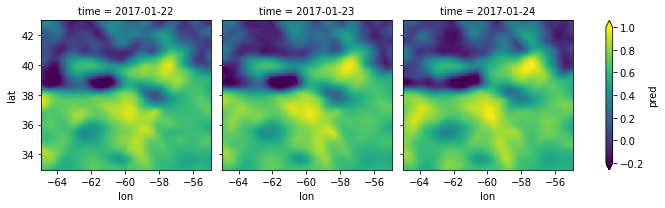

In [7]:
%matplotlib inline
data_4dvarnet.pred.isel(time=slice(10,13)).plot(col='time',vmin=-.2,vmax=1)

# 4. XP parameters

In [8]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# study area
#lon_min+180)%360-180
lon_min = 295.
lon_max = 305.
lat_min = 33.
lat_max = 43.
is_circle = False
time_min = '2017-01-13'
time_max = '2017-12-18'

# Outputs
bin_lat_step = 1.
bin_lon_step = 1.
bin_time_step = '1D'

# Spectral parameter
# C2 parameter
delta_t = 0.9434  # s
velocity = 6.77   # km/s
delta_x = velocity * delta_t
lenght_scale = 1000 # km

# 5. Import Cryosat-2 dataset

In [9]:
# get independent along-track
alontrack_independent_dataset= 'ose/eval_notebooks/inputs/dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc'
# Read along-track
ds_alongtrack = read_l3_dataset(alontrack_independent_dataset,
                                           lon_min=lon_min,
                                           lon_max=lon_max,
                                           lat_min=lat_min,
                                           lat_max=lat_max,
                                           time_min=time_min,
                                           time_max=time_max)
ds_alongtrack

<xarray.Dataset>
Dimensions:         (time: 46866)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-14T07:03:11.138080768 ... 2...
    longitude       (time) float64 304.1 304.1 304.1 304.1 ... 304.9 304.9 304.9
    latitude        (time) float64 33.06 33.11 33.17 33.23 ... 42.85 42.91 42.96
Data variables:
    cycle           (time) float64 89.0 89.0 89.0 89.0 ... 100.0 100.0 100.0
    track           (time) float64 237.0 237.0 237.0 237.0 ... 729.0 729.0 729.0
    dac             (time) float32 -0.1543 -0.1542 -0.1541 ... -0.0137 -0.0135
    lwe             (time) float32 0.014 0.014 0.014 0.014 ... 0.008 0.008 0.008
    mdt             (time) float32 0.542 0.543 0.544 ... -0.169 -0.17 -0.171
    ocean_tide      (time) float64 -0.412 -0.4127 -0.4134 ... -0.207 -0.208
    sla_filtered    (time) float32 -0.006 -0.02 -0.034 ... 0.164 0.155 0.145
    sla_unfiltered  (time) float32 0.008 -0.048 -0.01 ... 0.223 0.139 0.099
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

In [10]:
def define_ssh_var(file,var,id):
  data = xr.open_dataset(file)
  data = data.sel(time=slice(time[0],time[-1]),
                                  lat=slice(33,43),
                                  lon=slice(-65.0,-55))
  if 'obs_inp' in list(data.keys()):
      data = data.update({'obs':(('time','lat','lon'),data['obs_inp'].values)})
  data = data.update({'ssh':(('time','lat','lon'),data[var].values)})
  data = data.assign_coords(time=[np.datetime64(day) for day in data.time.values])
  newfile = file.replace(".nc","_method_"+id+".nc")
  data.to_netcdf(newfile)
  return newfile

file_oi = define_ssh_var(file_oi,'ssh',"DUACS")
file_4dvarnet = define_ssh_var(file,'pred',"4DVarNet")

methods = ['OI', '4DVarNet']
colors = ['k','red']

In [12]:
time_alongtrack, lat_alongtrack, lon_alongtrack, ssh_alongtrack, ssh_oi_interp = interp_on_alongtrack(file_oi,

           ds_alongtrack,

            lon_min=lon_min,

            lon_max=lon_max,

            lat_min=lat_min,

            lat_max=lat_max,

            time_min=time_min,

            time_max=time_max,

            is_circle=is_circle)


time_alongtrack, lat_alongtrack, lon_alongtrack, ssh_alongtrack, ssh_4dvarnet_interp = interp_on_alongtrack(file_4dvarnet,

           ds_alongtrack,

            lon_min=lon_min,

            lon_max=lon_max,

            lat_min=lat_min,

            lat_max=lat_max,

            time_min=time_min,

            time_max=time_max,

            is_circle=is_circle)


# 6.Compute spatial and temporal scores

In [13]:
# Compute spatial and temporal statistics
leaderboard_nrmse_oi, leaderboard_nrmse_std_oi = compute_stats(time_alongtrack,
                                                         lat_alongtrack,
                                                         lon_alongtrack,
                                                         ssh_alongtrack,
                                                         ssh_oi_interp,
                                                         bin_lon_step,
                                                         bin_lat_step,
                                                         bin_time_step,
                                                         output_filename='spa_stat_OI.nc',
                                                         output_filename_timeseries='TS_OI.nc')

# Compute spatial and temporal statistics
leaderboard_nrmse_4dvarnet, leaderboard_nrmse_std_4dvarnet = compute_stats(time_alongtrack,
                                                         lat_alongtrack,
                                                         lon_alongtrack,
                                                         ssh_alongtrack,
                                                         ssh_4dvarnet_interp,
                                                         bin_lon_step,
                                                         bin_lat_step,
                                                         bin_time_step,
                                                         output_filename='spa_stat_4dvarnet.nc',
                                                         output_filename_timeseries='TS_4dvarnet.nc')

INFO:root:  Results saved in: spa_stat_OI.nc
INFO:root: 
INFO:root:  Results saved in: TS_OI.nc
INFO:root: 
INFO:root:  MEAN RMSE Score = 0.8821815690463088
INFO:root: 
INFO:root:  STD RMSE Score = 0.03910914693400011
INFO:root:  Results saved in: spa_stat_4dvarnet.nc
INFO:root: 
INFO:root:  Results saved in: TS_4dvarnet.nc
INFO:root: 
INFO:root:  MEAN RMSE Score = 0.7629998100862522
INFO:root: 
INFO:root:  STD RMSE Score = 0.06300137322027743


# 7. Display spatial scores

/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartop

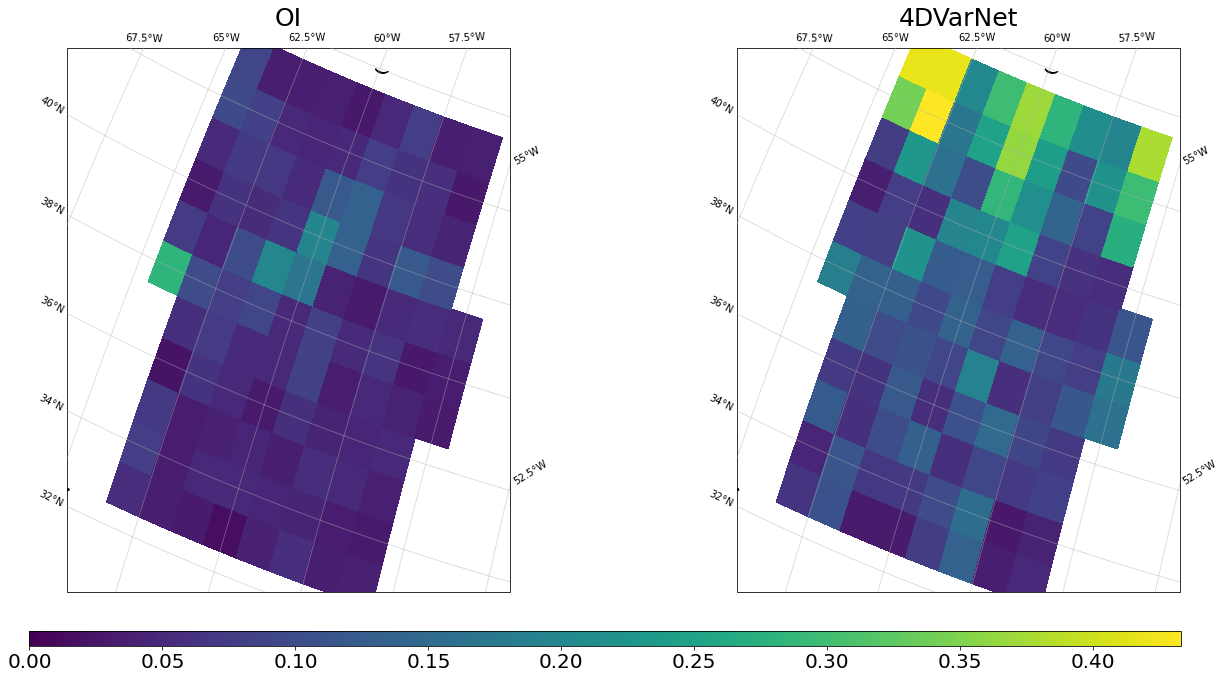

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
filenames = ['spa_stat_OI.nc','spa_stat_4DVarNet.nc']  
methods2 = ['OI', '4dvarnet']
ds = [ xr.open_dataset('spa_stat_'+methods2[i]+'.nc',group='diff').rmse.sel(lon=slice(lon_min,lon_max),
                                                                     lat=slice(lat_min,lat_max)) for i in range(len(filenames))]
maps_score(ds,ds[0].lon, ds[0].lat, methods, figsize=(20,10*len(methods)/2))

# 8. Display temporal scores

In [15]:
%matplotlib inline
# temporal scores        
plot_temporal_statistics(['TS_OI.nc', 'TS_4dvarnet.nc'],
                         methods,colors)

<xarray.Dataset>
Dimensions:       (time: 9)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-14 2017-01-16 ... 2017-01-30
Data variables:
    rms_OI        (time) float64 0.9054 0.929 0.8966 ... 0.8515 0.7945 0.8534
    rms_4DVarNet  (time) float64 0.8273 0.8735 0.7419 ... 0.769 0.6381 0.7146
Launching server at http://localhost:38577


# 9. Compute and display spectral scores

INFO:root:  Results saved in: spectrum_oi.nc
INFO:root:  Results saved in: spectrum_4dvarnet.nc
INFO:root: 
INFO:root:  Minimum spatial scale resolved = 111km


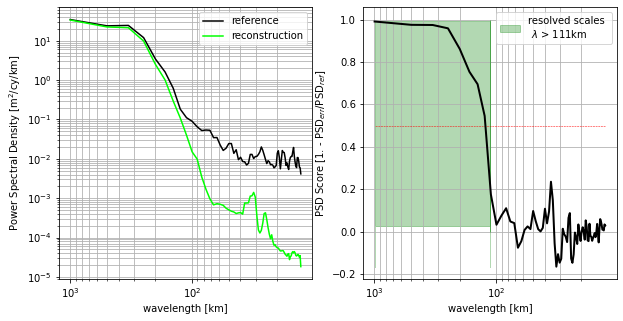

INFO:root: 
INFO:root:  Minimum spatial scale resolved = 121km


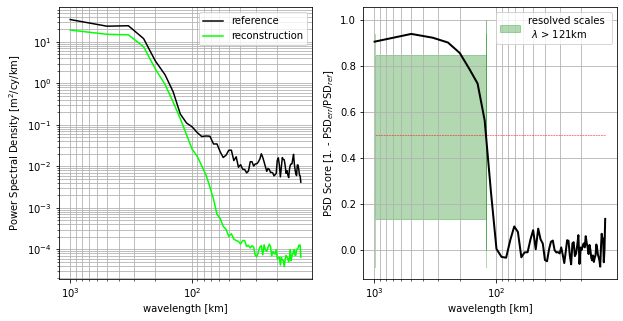

INFO:root: 
INFO:root:  Minimum spatial scale resolved = 111km


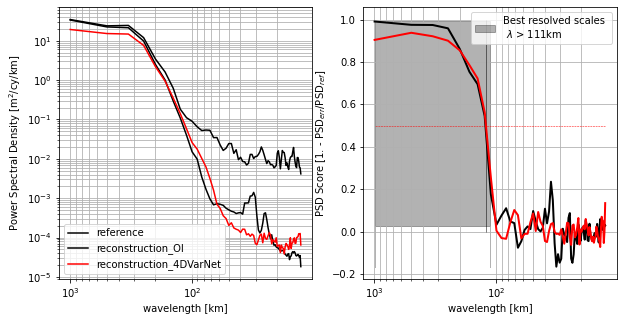

[array(111.54879592), array(121.73829869)]

In [16]:
# Compute spectral scores
compute_spectral_scores(time_alongtrack,
                        lat_alongtrack,
                        lon_alongtrack,
                        ssh_alongtrack,
                        ssh_oi_interp,
                        lenght_scale,
                        delta_x,
                        delta_t,
                        'spectrum_oi.nc')
compute_spectral_scores(time_alongtrack,
                        lat_alongtrack,
                        lon_alongtrack,
                        ssh_alongtrack,
                        ssh_4dvarnet_interp,
                        lenght_scale,
                        delta_x,
                        delta_t,
                        'spectrum_4dvarnet.nc')

# Compute spectral scores
leaderboard_psds_score_oi = plot_psd_score('spectrum_oi.nc')
leaderboard_psds_score_4dvarnet = plot_psd_score('spectrum_4dvarnet.nc')

plot_psd_score_intercomparison(['spectrum_oi.nc', 'spectrum_4dvarnet.nc'], 
                               methods,colors)

In [18]:
# Print leaderboard
data = np.array([['OI','4DVarNet'],
         [leaderboard_nrmse_oi,leaderboard_nrmse_4dvarnet],
         [leaderboard_nrmse_std_oi,leaderboard_nrmse_std_4dvarnet],             
         [int(leaderboard_psds_score_oi),int(leaderboard_psds_score_4dvarnet)]]).T
Leaderboard = pd.DataFrame(data,
                           columns=['Method',
                                    "µ(RMSE) ",
                                    "σ(RMSE)",
                                    'λx (km)'])
print("Summary of the leaderboard metrics:")
Leaderboard
print(Leaderboard.to_markdown())

Summary of the leaderboard metrics:
|    | Method   |   µ(RMSE)  |   σ(RMSE) |   λx (km) |
|---:|:---------|-----------:|----------:|----------:|
|  0 | OI       |   0.882182 | 0.0391091 |       111 |
|  1 | 4DVarNet |   0.763    | 0.0630014 |       121 |


# 10. Display SSH and GradSSH fields

/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartop

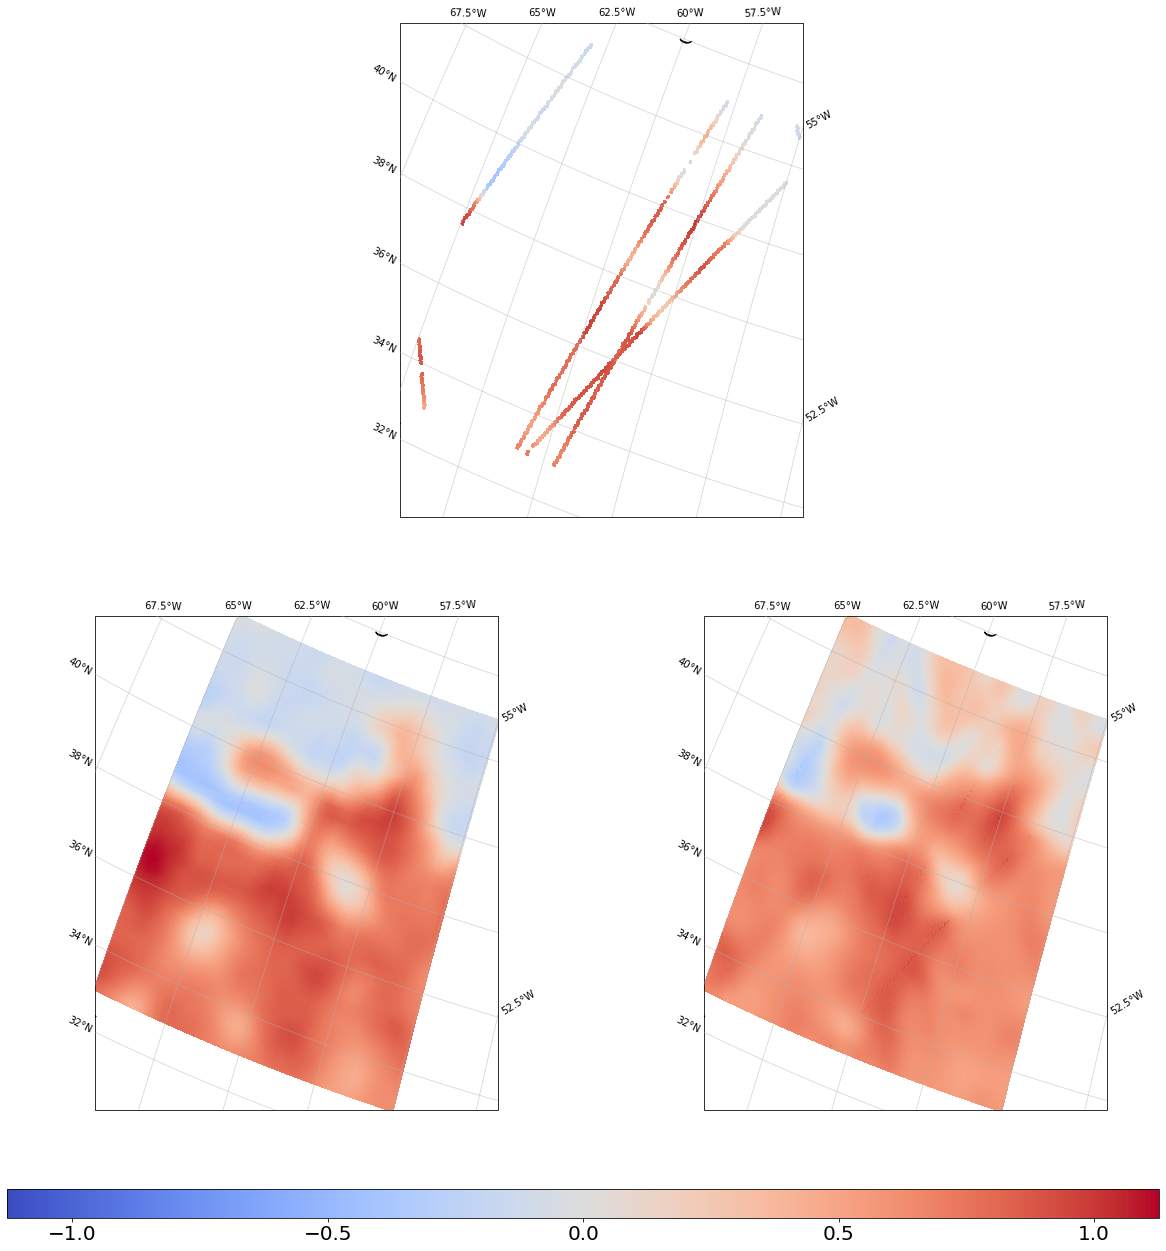

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
itime = 10

filenames = [file_4dvarnet,file_oi,file_4dvarnet]
vars = ['obs']
vars.extend(methods)
vars2 = ['gt','ssh','pred']
ds = [ xr.open_dataset(filenames[i])[vars2[i]].isel(time=itime) for i in range(len(filenames))] 
plot_maps(ds,ds[0].lon,ds[0].lat,
          grad=False,orthographic=True, methods=vars, figsize=(20,10+10*len(methods)/2))

/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/users/local/m19beauc/miniconda3/envs/4dvarnet/lib/python3.9/site-packages/cartop

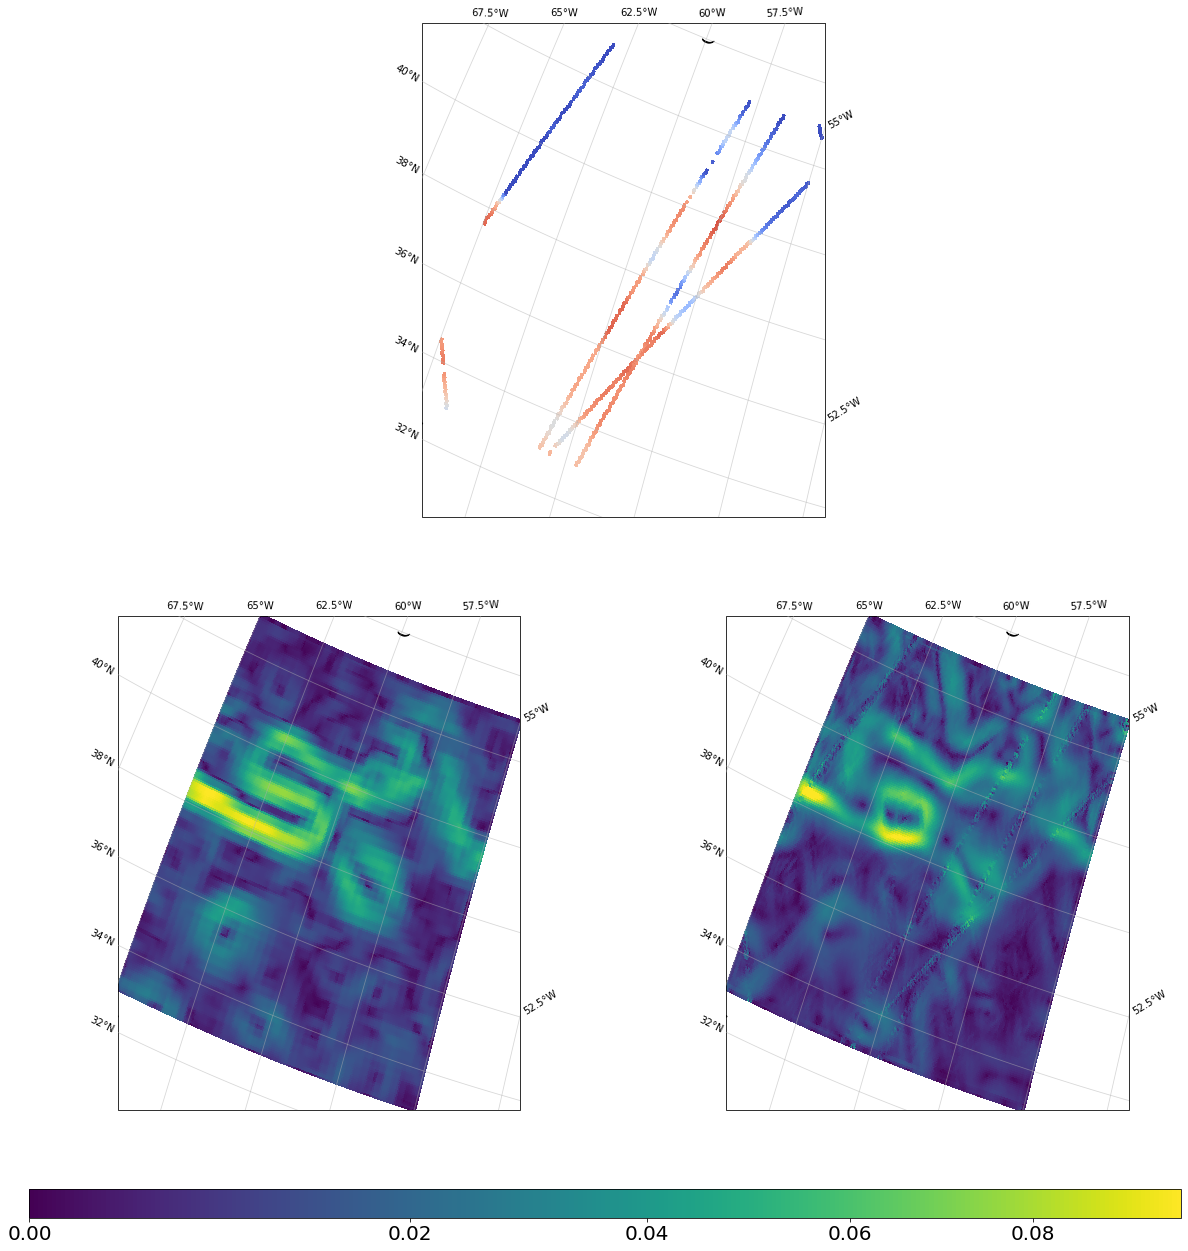

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
plot_maps(ds,ds[0].lon,ds[0].lat,
          grad=True,orthographic=True, methods=vars, figsize=(20,10+10*len(methods)/2))

In [21]:
# Clean
os.remove('spa_stat_4dvarnet.nc')
os.remove('spectrum_4dvarnet.nc')
os.remove('TS_4dvarnet.nc')
os.remove('spa_stat_OI.nc')
os.remove('spectrum_oi.nc')
os.remove('TS_OI.nc')